# Examples: `image` 

In [1]:
import sys
sys.path.append('..')

from ipywidgets import interact
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import psdist.bunch as psd
import psdist.image as psi
import psdist.plotting as psp
from psdist import utils

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

## 2D image 

In [3]:
res = 50
state = np.random.RandomState(1951)
xx = np.linspace(-5.0, 5.0, res)
X, Y = np.meshgrid(xx, xx, indexing='ij')
f = np.zeros((res, res))
for _ in range(4):
    sig = state.uniform(0.5, 1.5, size=2)
    mu = state.uniform(-2.0, 2.0, size=2)
    f += np.exp(-0.5 * (((X - mu[0]) / sig[0])**2 + ((Y - mu[1]) / sig[1])**2))
f = f + 0.01 * np.max(f)
f = f / np.max(f)

In [4]:
@interact(thresh=(-5.0, 0.0), log=False)
def update(log, thresh):
    fig, ax = pplt.subplots()
    ax = psp.image(
        f, x=xx, y=xx, ax=ax,
        profx=True, profy=True,
        thresh=10.0**thresh, 
        rms_ellipse=True, 
        rms_ellipse_kws=dict(color='white'), 
        colorbar=True,
        norm=('log' if log else None),
        vmax=1.0,
    )

interactive(children=(Checkbox(value=False, description='log'), FloatSlider(value=-2.5, description='thresh', …

## ND image 

In [5]:
res = 50
n = 4
dims = ["x", "x'", "y", "y'"]

shape = tuple(n * [res])
xmax = 6.0
coords = n * [np.linspace(-xmax, xmax, res)]
COORDS = np.meshgrid(*coords, indexing='ij')
R = np.sqrt(np.sum([C**2 for C in COORDS]))
f = np.zeros(shape)
for _ in range(12):
    sig = state.uniform(0.5, 1.5, size=n)
    mu = state.uniform(-3.0, 3.0, size=n)
    argument = np.zeros(shape)
    for i in range(n):
        argument += ((COORDS[i] - mu[i]) / sig[i])**2
    f += np.exp(-0.5 * argument)
# f += 0.01 * np.sin(2.5 * R)**2
f += 1.0 * np.sin(COORDS[0] * COORDS[3]) * np.exp(-0.5 * R)
# f += 1.0 * np.sin(COORDS[2] * COORDS[1]) * np.exp(-0.5 * R)
# f += 1.0 * np.sin(COORDS[2] * COORDS[1] * COORDS[0] * COORDS[3]) * np.exp(-0.5 * R**2)
f = (f - np.min(f)) + 0.0001 * np.max(f)
f = f / np.max(f)

### Corner plot 

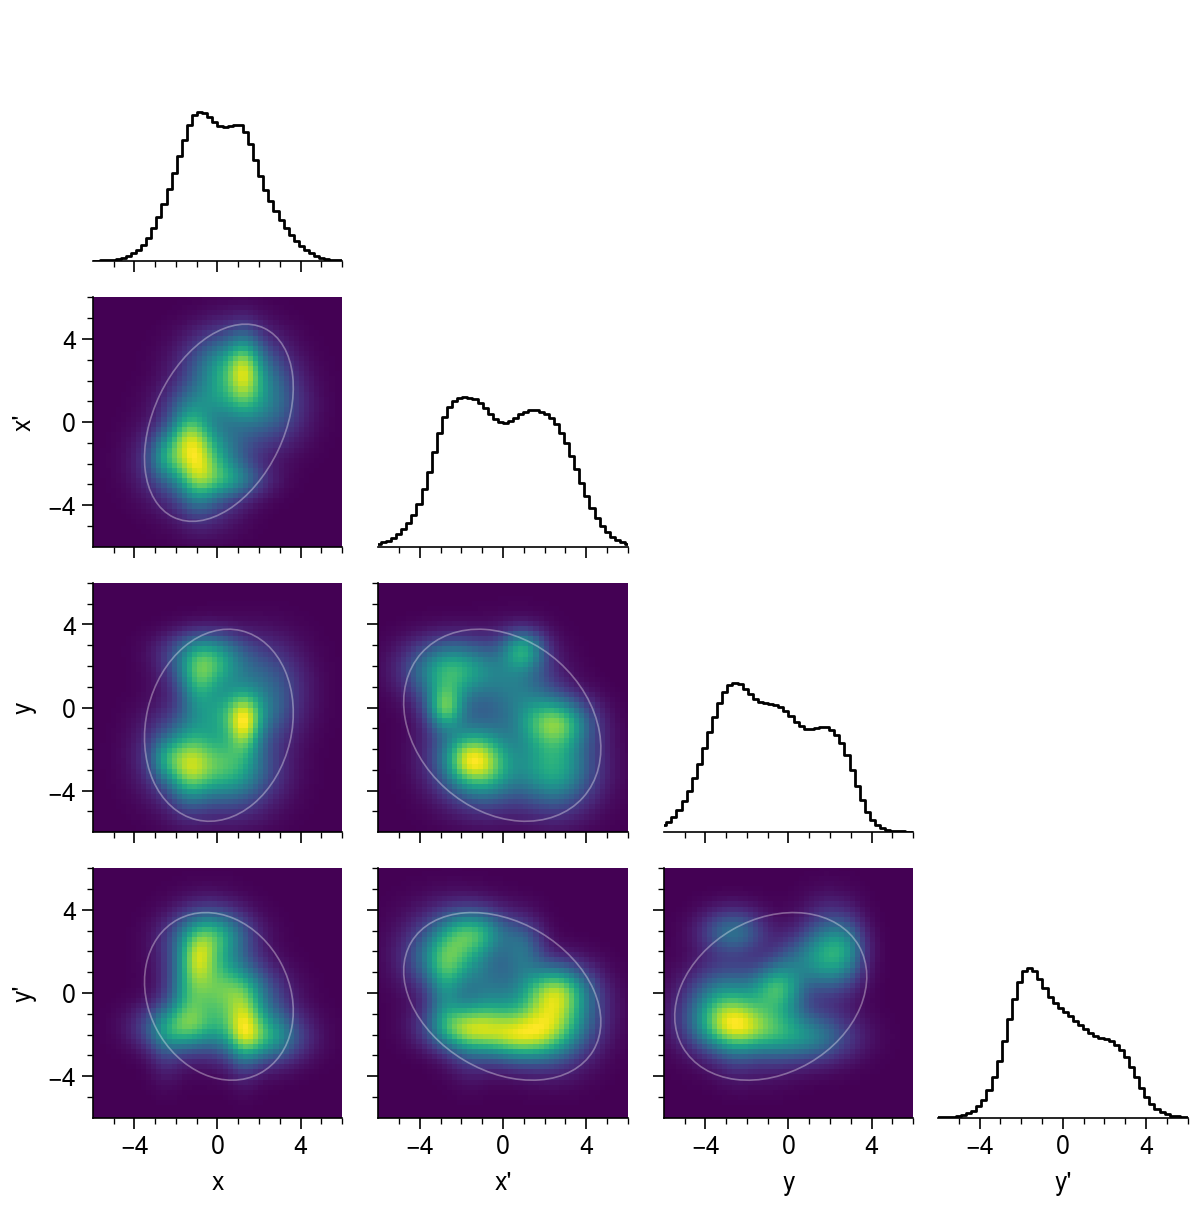

In [6]:
axes = psp.corner(
    data=f,
    coords=coords,
    diag_kind='step',
    prof=False,
    labels=dims,
    rms_ellipse=True,
    rms_ellipse_kws=dict(color='white', alpha=0.35, level=2.0),
    norm=None,
)

### Slice matrix

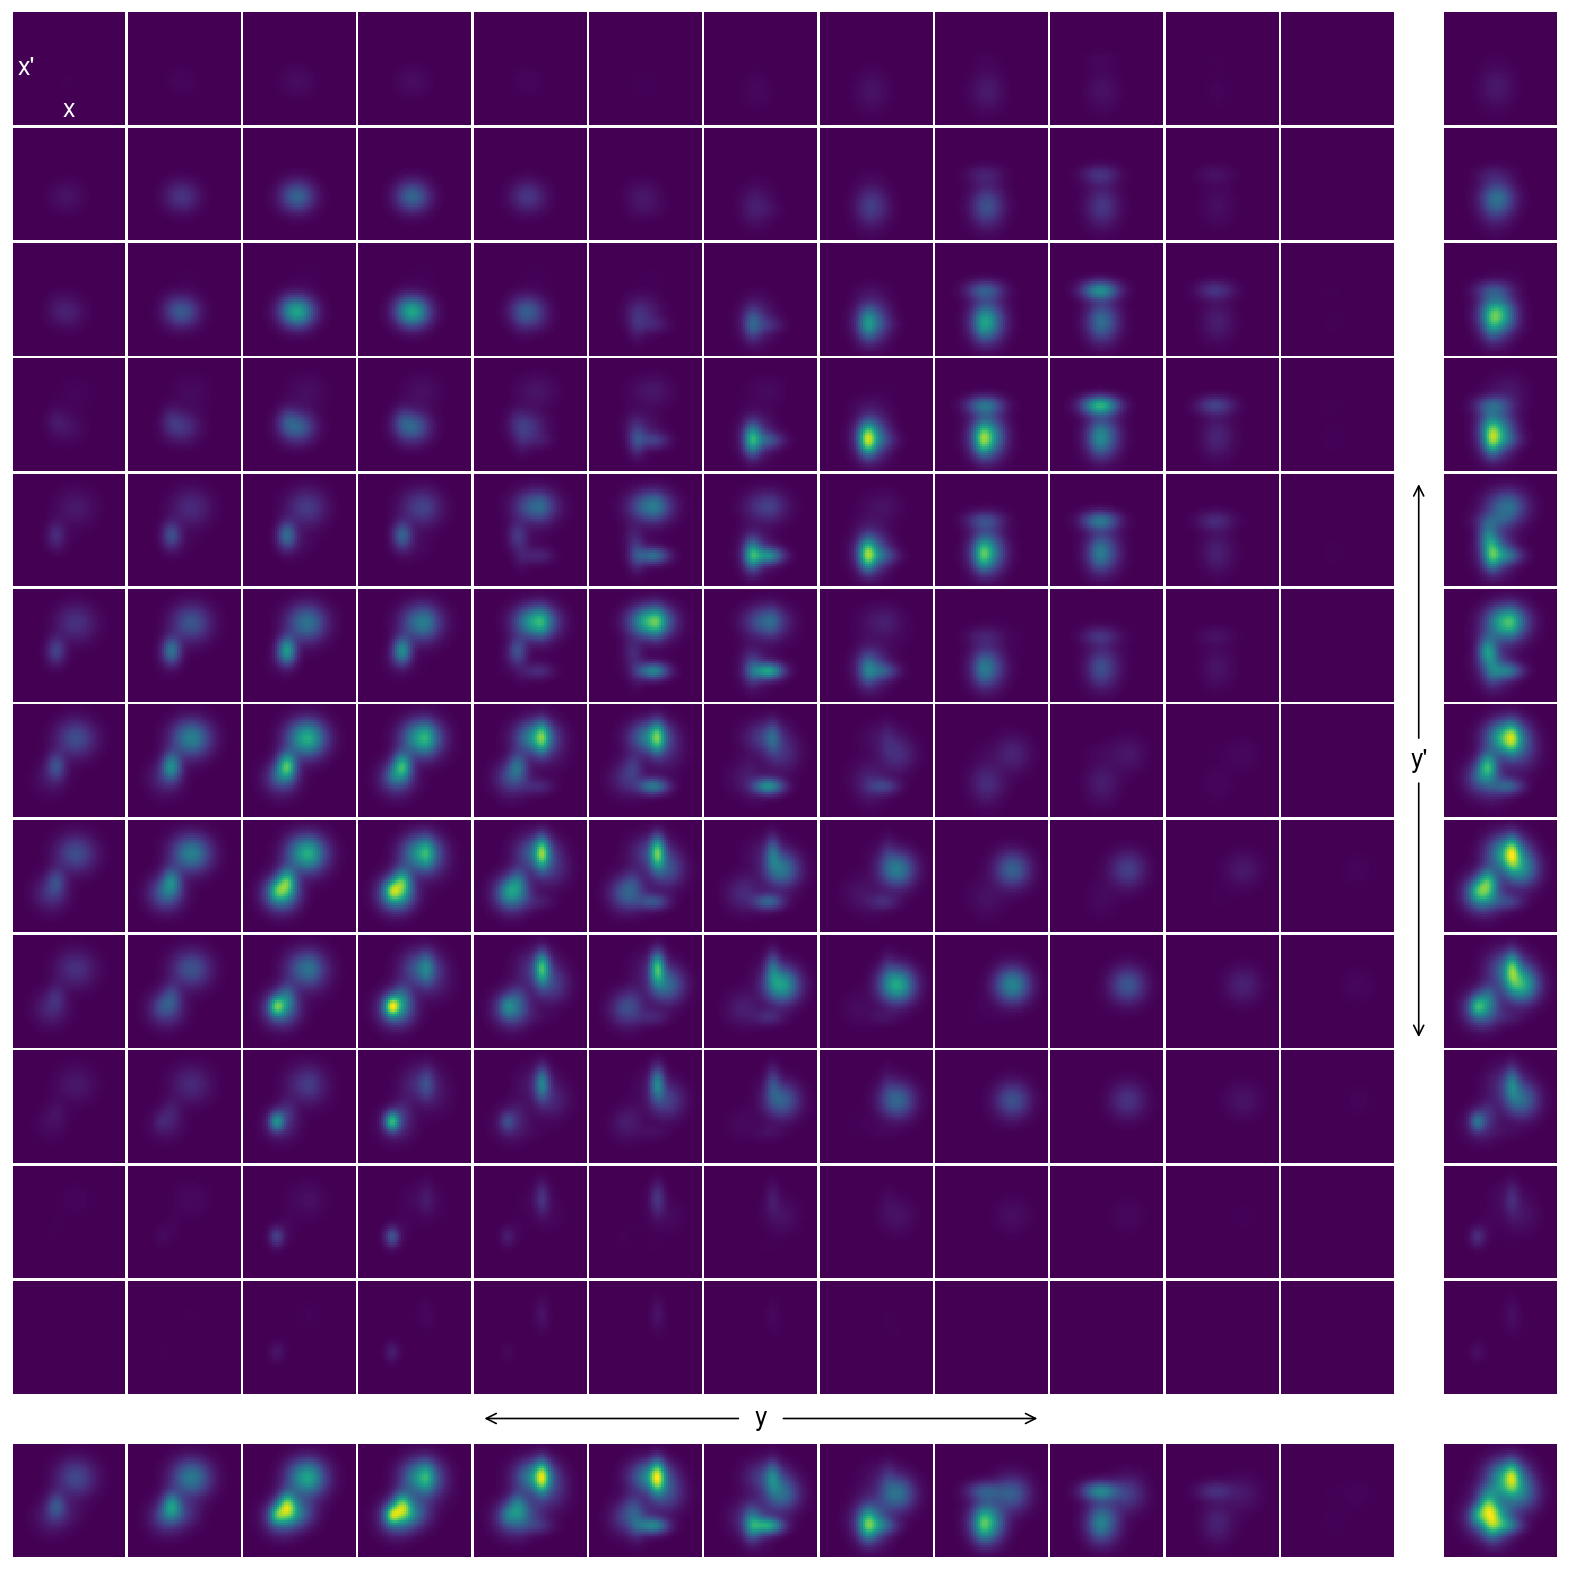

In [7]:
axes = psp.slice_matrix(
    f, 
    axis_view=(0, 1),
    axis_slice=(2, 3), 
    nrows=12, ncols=12, 
    coords=coords, 
    dims=dims, 
    pad=0.1,
    vmax=1.0  # share colormaps
)

### 1D (partial) projection

In [8]:
psp.interactive_proj1d(f, coords=coords, dims=dims)

interactive(children=(Dropdown(description='dim', options=('x', "x'", 'y', "y'"), value='x'), Checkbox(value=F…

### 2D (partial) projections 

In [9]:
psp.interactive_proj2d(f, coords=coords, dims=dims)

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

### Contour slices

High-dimensional contour slices are obtained using thresholded projections of the distribution onto specified axes. This is an approximation that works okay when the resolution is high. For example:

In [10]:
@interact(resolution=(5, 100))
def update(resolution):
    xx = np.linspace(-5.0, 5.0, resolution)
    X, Y = np.meshgrid(xx, xx, indexing='ij')
    _image = np.zeros((resolution, resolution))
    _state = np.random.RandomState(1952)
    for _ in range(4):
        sig = _state.uniform(0.5, 1.5, size=2)
        mu = _state.uniform(-2.0, 2.0, size=2)
        _image += np.exp(-0.5 * (((X - mu[0]) / sig[0])**2 + ((Y - mu[1]) / sig[1])**2))
    _image = _image / np.max(_image)

    fig, axes = pplt.subplots(ncols=3, figwidth=8, share=False)
    axes.format(xspineloc='neither', yspineloc='neither')
    axes[0].pcolormesh(_image.T, colorbar=True)
    axes[1].pcolormesh(_image.T, discrete=True, colorbar=True)
    axes[2].contourf(_image.T, colorbar=True)
    axes.format(toplabels=['Image', 'Discrete contours', 'Smooth contours'], toplabels_kw=dict(fontweight='normal'))
    plt.show()

interactive(children=(IntSlider(value=52, description='resolution', min=5), Output()), _dom_classes=('widget-i…

#### 1D projection, 4D contour slice

Here, we observe the 1D projection of the distribution within a 4D contour slice in the other dimensions.

In [11]:
@interact(
    dim=widgets.Dropdown(options=dims, value=dims[0]),
    levels=widgets.FloatRangeSlider(
        description='4D thresh', min=0.0, max=1.0, value=(0.0, 1.0), step=0.001,
        continuous_update=True,
    ),
)
def update(dim, levels):
    lmin, lmax = levels
    axis = dims.index(dim)
    proj = psi.project1d_contour(f, axis=axis, lmin=lmin, lmax=lmax)
    
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.format(xlabel=dims[axis])
    ax.plot(coords[axis], proj, color='black')
    plt.show()

interactive(children=(Dropdown(description='dim', options=('x', "x'", 'y', "y'"), value='x'), FloatRangeSlider…

We can do the same thing with a 2D projection of the distribution within a 3D contour slice in the other dimensions.

In [12]:
@interact(
    dim1=widgets.Dropdown(options=dims, value=dims[0]),
    dim2=widgets.Dropdown(options=dims, value=dims[1]),
    levels=widgets.FloatRangeSlider(
        description='3D thresh', min=0.0, max=1.0, value=(0.0, 1.0), step=0.001, 
        readback_format='.3f',
    ),
    log=False,
)
def update(levels, dim1, dim2, log, **plot_kws):
    if dim1 == dim2:
        return
    axis = (dims.index(dim1), dims.index(dim2))
    lmin, lmax = levels
    proj = psi.project2d_contour(f, axis=axis, lmin=lmin, lmax=lmax)
    
    fig, ax = pplt.subplots()
    plot_kws['norm'] = 'log' if log else None
    plot_kws.setdefault('thresh', 10.0**-3.0)
    plot_kws.setdefault('thresh_type', 'frac')
    plot_kws.setdefault('colorbar', True)
    plot_kws.setdefault('profx', True)
    plot_kws.setdefault('profy', True)
    plot_kws.setdefault('floor', 1.0 if log else None)
    ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
    psp.image(proj, x=coords[axis[0]], y=coords[axis[1]], ax=ax, colorbar=True)
    ax.format(xlim=sorted(ax.get_xlim()))
    plt.show()

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='3D thresh', max=1.0, step=0.001), Dropdo…